In [1]:
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import numpy as np

- Indentify the top 20 retrievable CORUM complexes based on their size.
- Plot all the replicable profiles from these complexes.
- Size of the data points should be proportional to the replicate retrieval mAP score.

In [2]:
label_count = 15
member_count_threshold = 5
label_retrieval_threshold = 0.1

filename = "corum_complex"
label_column_name = "Metadata_corum_complex_list"
metadata_column_name = "Metadata_complexname"

# filename = "wikipathway"
# label_column_name = "Metadata_wikipathway_list"
# metadata_column_name = "Metadata_wikipathway"

In [3]:
# Read profiles

crispr_profiles_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected.parquet"
)

crispr_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,X_1,X_2,X_3,X_4,X_5,X_6,...,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259
0,source_13,CP-CC9-R1-01,A02,JCP2022_800002,-0.223417,-0.049487,-0.826231,0.345093,-0.273055,-0.186349,...,-0.041767,0.073491,-0.157532,-0.071469,-0.037753,0.053746,0.023982,0.156385,-0.064430,0.004538
1,source_13,CP-CC9-R1-01,K14,JCP2022_804257,-0.066288,0.076715,-1.067553,-0.367578,0.122728,-0.823368,...,0.034426,0.033929,0.102059,0.144348,0.208035,0.050269,0.001003,0.027160,-0.040426,-0.049395
2,source_13,CP-CC9-R1-01,L23,JCP2022_800002,-0.079349,-0.016958,-0.277558,-0.625543,-0.236846,-0.140912,...,0.025519,0.134598,-0.018768,-0.079568,-0.214031,0.031374,-0.079467,0.001434,0.063802,-0.003757
3,source_13,CP-CC9-R1-01,K02,JCP2022_800001,-0.271417,-0.117471,0.462461,-0.480330,-0.406793,-0.691130,...,-0.129316,0.224771,0.204519,-0.081960,0.038231,0.081065,-0.009409,0.077791,-0.043725,0.086840
4,source_13,CP-CC9-R1-01,I08,JCP2022_800001,0.008612,-0.059106,-1.081568,-1.246591,0.025878,-0.241614,...,0.005117,-0.077804,0.038525,0.089097,0.074524,-0.120086,-0.038295,0.024144,0.140383,-0.023736


In [4]:
# Read label retrieval scores

label_df = (
    pd.read_parquet(
        f"../03.retrieve-annotations/output/{filename}_retrieval.parquet",
        columns=[
            f"{label_column_name}",
            "mean_average_precision",
            "below_corrected_p",
            "Modality",
        ],
    )
    .query("Modality=='CRISPR'")
    .query("below_corrected_p==True")
    .drop(columns=["Modality", "below_corrected_p"])
    .rename(
        columns={"mean_average_precision": f"{filename}_retrieval_mean_average_precision"}
    )
)
label_df.head()

,Metadata_corum_complex_list,corum_complex_retrieval_mean_average_precision
1329,26S proteasome,0.873434
1331,2AR-mGluR2 complex,1.000000
1333,"39S ribosomal subunit, mitochondrial",0.250996
1335,"40S ribosomal subunit, cytoplasmic",0.656445
1338,53BP1-containing complex,0.334557


In [5]:
# Read phenotypic activity scores

phenotypic_activity_df = (
    pd.read_csv(
        "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected.csv.gz",
        usecols=[
            "Metadata_JCP2022",
            "mean_average_precision",
            "below_corrected_p",
        ],
    )
    .query("below_corrected_p==True")
    .drop(columns=["below_corrected_p"])
    .rename(
        columns={
            "mean_average_precision": "phenotypic_activity_mean_average_precision",
        }
    )
)
phenotypic_activity_df.head()

,Metadata_JCP2022,phenotypic_activity_mean_average_precision
2,JCP2022_800005,0.819167
4,JCP2022_800007,0.819028
6,JCP2022_800009,0.499945
7,JCP2022_800010,0.551017
8,JCP2022_800011,0.622827


In [6]:
# Add crispr annotations

crispr_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep='\t',
    usecols=["Metadata_JCP2022", "Metadata_Symbol", f"{metadata_column_name}"],
)

crispr_metadata_df.head()

,Metadata_JCP2022,Metadata_Symbol,Metadata_complexname
0,JCP2022_800001,no-guide,NaN
1,JCP2022_800002,non-targeting,NaN
2,JCP2022_800003,A2M,A2M-BCHE complex
3,JCP2022_800004,A3GALT2,NaN
4,JCP2022_800005,A4GALT,NaN


In [7]:
crispr_metadata_df = (
    crispr_metadata_df.assign(
    col=crispr_metadata_df[f"{metadata_column_name}"].str.split("|")
)
.explode("col")
.rename(columns={"col": f"{label_column_name}"})
.drop(columns=[f"{metadata_column_name}"])
)

In [8]:
# Merging all the dataframes

crispr_profiles_df = (
    crispr_profiles_df.merge(crispr_metadata_df, on="Metadata_JCP2022", how="inner")
    .merge(phenotypic_activity_df, on="Metadata_JCP2022", how="inner")
    .merge(label_df, on=f"{label_column_name}", how="inner")
)

crispr_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,X_1,X_2,X_3,X_4,X_5,X_6,...,X_254,X_255,X_256,X_257,X_258,X_259,Metadata_Symbol,Metadata_corum_complex_list,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
0,source_13,CP-CC9-R1-02,L06,JCP2022_804038,0.953609,0.540883,0.412631,-2.039853,0.054344,-0.519369,...,0.170757,0.085352,-0.115999,-0.108671,0.151156,-0.140684,MARS,Multisynthetase complex,0.961389,0.132588
1,source_13,CP-CC9-R2-02,L06,JCP2022_804038,-0.011073,0.165757,0.480242,-2.275932,-0.049616,0.817929,...,-0.065458,-0.104913,0.196416,0.077230,0.184945,-0.229479,MARS,Multisynthetase complex,0.961389,0.132588
2,source_13,CP-CC9-R3-02,L06,JCP2022_804038,0.074538,0.084689,0.122796,-1.636654,-0.073682,0.950761,...,0.110416,0.069506,-0.026896,0.123059,0.059691,-0.042337,MARS,Multisynthetase complex,0.961389,0.132588
3,source_13,CP-CC9-R5-02,L06,JCP2022_804038,-0.216173,-0.090806,0.495160,-1.974751,0.051584,0.263396,...,0.260180,0.198414,0.000019,-0.123721,-0.012955,-0.012735,MARS,Multisynthetase complex,0.961389,0.132588
4,source_13,CP-CC9-R7-02,L06,JCP2022_804038,-0.069769,-0.018367,0.127862,-0.623233,-0.005441,0.872407,...,0.010037,-0.312765,0.033059,0.000712,-0.113398,-0.032137,MARS,Multisynthetase complex,0.961389,0.132588


In [9]:
# Consensus profile

crispr_profiles_df = utils.consensus(crispr_profiles_df, "Metadata_Symbol")
crispr_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_corum_complex_list,X_1,X_2,X_3,X_4,...,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
0,source_13,CP-CC9-R1-02,L06,JCP2022_804038,MARS,Multisynthetase complex,-0.040421,0.033161,0.446436,-1.805703,...,0.094965,0.031801,0.065088,0.002290,0.016539,-0.047385,0.023368,-0.088160,0.961389,0.132588
1,source_13,CP-CC9-R1-02,D18,JCP2022_802154,EPRS,Multisynthetase complex,-0.156204,0.018064,-0.265274,-2.547554,...,0.015708,-0.181611,-0.084704,-0.015054,0.036487,0.164912,-0.064195,-0.077227,0.988889,0.132588
2,source_13,CP-CC9-R1-04,J03,JCP2022_805842,RARS,Multisynthetase complex,-0.269487,-0.056378,-1.319576,1.266253,...,-0.059735,0.001472,0.126151,-0.210693,-0.082407,0.009524,0.019728,0.009613,0.983333,0.132588
3,source_13,CP-CC9-R1-04,P16,JCP2022_803539,KARS,Multisynthetase complex,-0.156822,0.020398,-1.035207,-3.408246,...,0.049822,-0.161473,0.171909,-0.170719,-0.018935,0.132493,0.151614,-0.077135,0.972222,0.132588
4,source_13,CP-CC9-R1-07,J18,JCP2022_803309,IARS,Multisynthetase complex,-0.128099,0.012472,0.195676,-1.549664,...,0.059253,-0.008192,0.041032,0.125767,-0.075587,0.066098,0.000316,-0.055465,1.000000,0.132588


In [10]:
large_labels = (
    crispr_profiles_df[f"{label_column_name}"]
    .value_counts()
    .reset_index()
    .query(f"{label_column_name} >= @member_count_threshold")["index"]
    .to_list()
)

selected_labels = (
    crispr_profiles_df.query(f"{label_column_name} in @large_labels")
    .sort_values(by=f"{filename}_retrieval_mean_average_precision", ascending=False)
    .query(f"{filename}_retrieval_mean_average_precision >= @label_retrieval_threshold")
    .drop_duplicates(subset=[f"{label_column_name}"], keep="first")
    .nlargest(label_count, f"{filename}_retrieval_mean_average_precision")
)[f"{label_column_name}"].to_list()

In [11]:
crispr_profiles_df = crispr_profiles_df.query(f"{label_column_name} in @selected_labels")
crispr_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_corum_complex_list,X_1,X_2,X_3,X_4,...,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
80,source_13,CP-CC9-R1-02,D16,JCP2022_806633,SMARCB1,"Spliceosome, E complex",-0.603743,-0.119425,1.478871,0.563461,...,0.037973,0.050687,0.117558,0.037067,-0.028439,-0.064747,-0.046575,-0.015625,0.895757,0.103546
81,source_13,CP-CC9-R1-03,A08,JCP2022_801734,DDX39A,"Spliceosome, E complex",-0.212121,-0.036744,0.688252,-0.403093,...,0.005182,0.018568,-0.117870,0.016442,-0.016556,-0.021866,-0.039671,0.081574,0.531245,0.064122
82,source_13,CP-CC9-R1-06,E13,JCP2022_804950,PCBP2,"Spliceosome, E complex",-0.000215,-0.041146,0.148997,2.625807,...,0.087428,-0.068284,-0.028379,0.035713,-0.065997,0.006999,-0.091682,0.070737,1.000000,0.064122
83,source_13,CP-CC9-R1-09,C07,JCP2022_805416,PPIH,"Spliceosome, E complex",-0.023967,-0.029880,0.557171,0.428244,...,0.068893,0.082768,0.004254,0.145698,-0.001709,-0.042971,-0.054965,0.105185,0.585404,0.088054
84,source_13,CP-CC9-R1-11,L14,JCP2022_801735,DDX39B,"Spliceosome, E complex",0.006805,-0.101319,0.035711,3.668154,...,-0.157591,-0.069168,-0.082875,0.041894,-0.068158,0.002392,-0.295270,0.009087,1.000000,0.197711


In [12]:
# Create umaps
X = utils.get_featuredata(crispr_profiles_df)
crispr_projection_2d = UMAP(n_components=2, random_state=12527).fit_transform(X)
crispr_profiles_df["umap 1"] = crispr_projection_2d[:, :1].flatten()
crispr_profiles_df["umap 2"] = crispr_projection_2d[:, 1:2].flatten()

# shuffle the data points
crispr_profiles_df = crispr_profiles_df.sample(frac=1, random_state=12527).reset_index(drop=True)

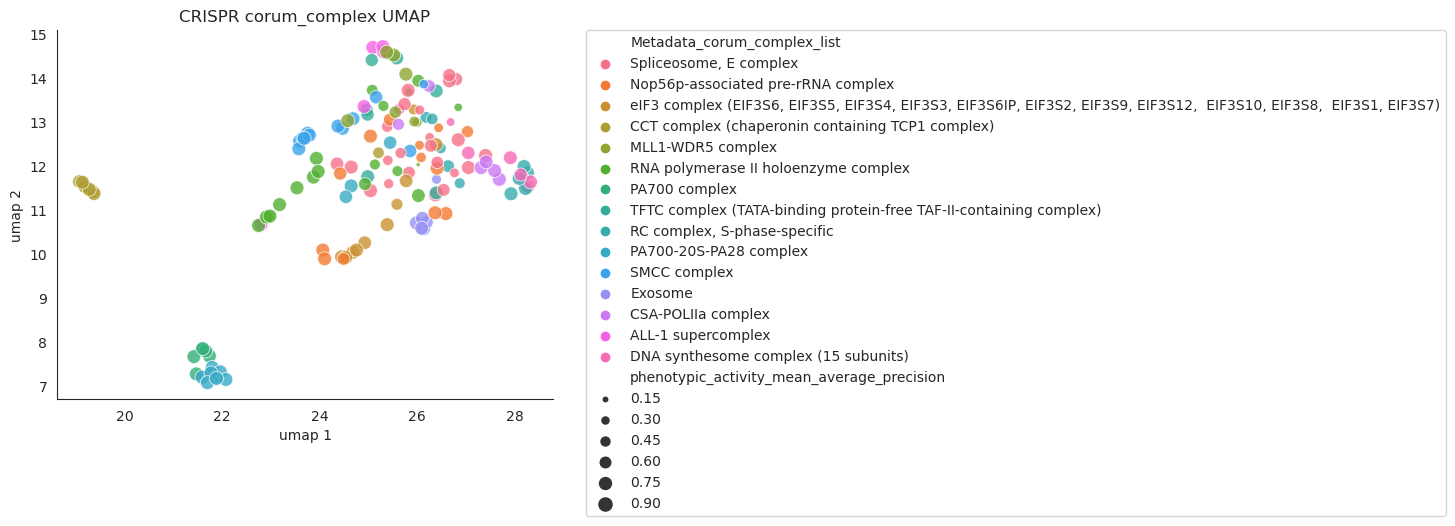

In [13]:
# Visualize UMAP

sns.set_style("white")

sns.scatterplot(
    data=crispr_profiles_df,
    x="umap 1",
    y="umap 2",
    hue=f"{label_column_name}",
    size="phenotypic_activity_mean_average_precision",
    sizes=(10, 100),
    alpha=0.8,
).set_title(f"CRISPR {filename} UMAP")

sns.despine()
plt.legend(bbox_to_anchor=(2.8, 1), loc="upper right", borderaxespad=0, ncol=1)

plt.savefig(
    f"figures/crispr_morphmap.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/crispr_morphmap.svg", bbox_inches="tight", dpi=300
)